# **Customer Churn Dataset**


# 1.	Import Libraries/Dataset

In [1]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for pre-processing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn models (Classifiers)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Scikit-learn metrics for performance evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
try:
    df = pd.read_csv('customer_churn_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'customer_churn_dataset.csv' not found.")

Dataset loaded successfully.


# 2.	Data Visualization and Exploration

In [3]:
print("===== Part 2-a =====")
print("--- First 2 Rows of the Dataset ---")
print(df.head(2))

print("\n--- Dataset Info (Data Types and Non-Null Counts) ---")
df.info()

print("\n--- Descriptive Statistics for Numerical Features ---")
print(df.describe())

print("\n--- Checking for Missing Values ---")
print(df.isnull().sum())

===== Part 2-a =====
--- First 2 Rows of the Dataset ---
  customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Cust_1    Male            0.0     Yes         No     2.0          Yes   
1     Cust_2  Female            1.0      No         No     NaN          Yes   

  MultipleLines InternetService OnlineSecurity         OnlineBackup  Churn  
0            No             NaN             No  No internet service      1  
1            No     Fiber optic            Yes                  Yes      0  

--- Dataset Info (Data Types and Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       10000 non-null  object 
 1   gender           9000 non-null   object 
 2   SeniorCitizen    9000 non-null   float64
 3   Partner          9000 non-null   object 
 4   Dependents       9000 non-null

===== Part 2-b =====


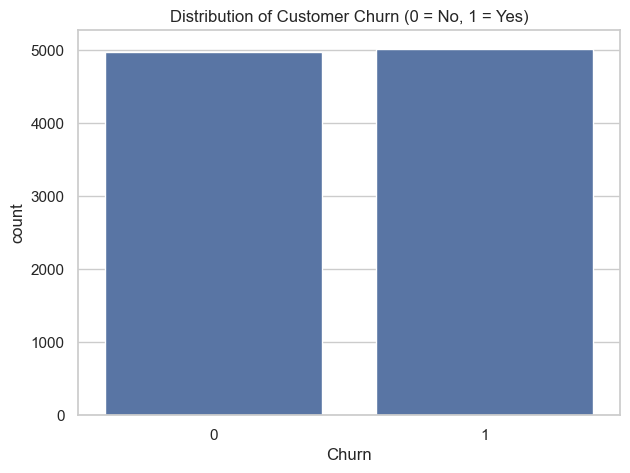

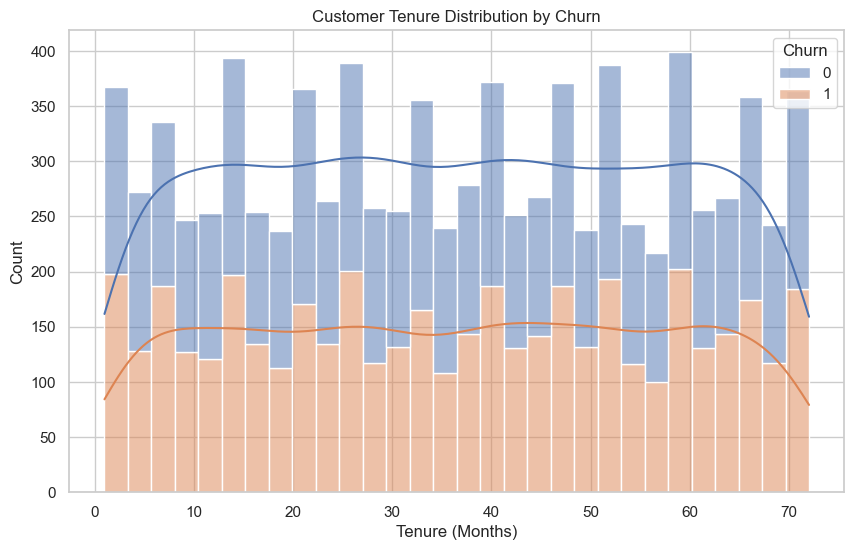

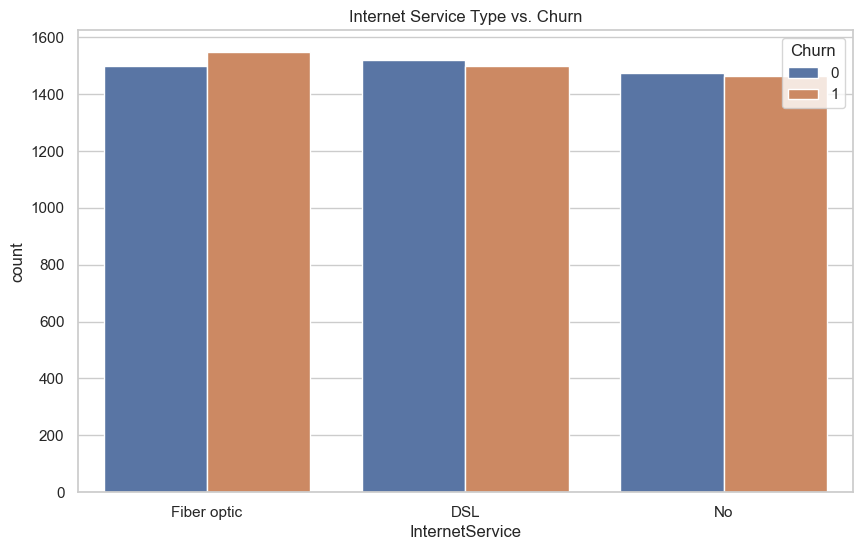

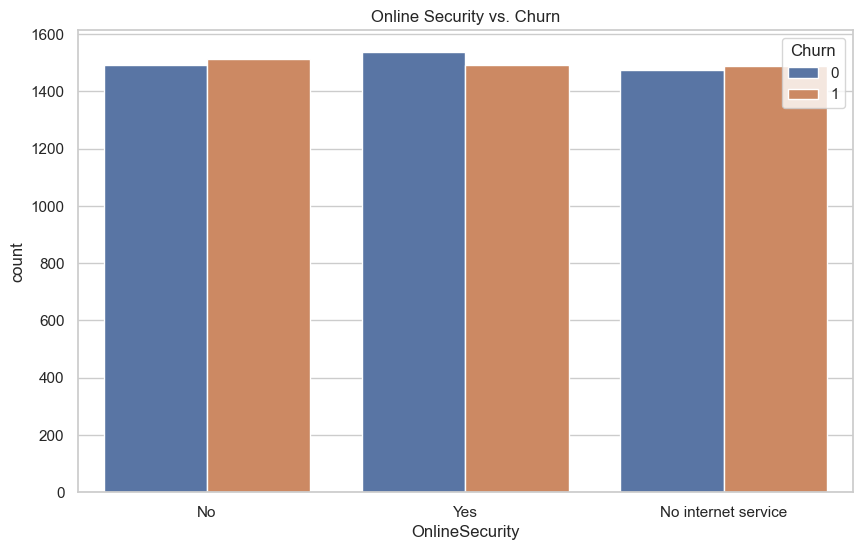

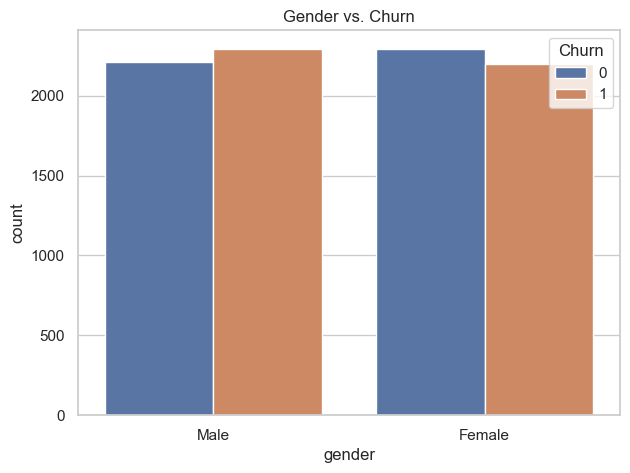

In [4]:
print("===== Part 2-b =====")
# --- Data Visualizations ---

# Set plot style
sns.set(style="whitegrid")

# 1. Target Variable Distribution (Churn)
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn (0 = No, 1 = Yes)')
plt.show()

# 2. Tenure vs. Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, bins=30)
plt.title('Customer Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.show()

# 3. Internet Service vs. Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Internet Service Type vs. Churn')
plt.show()

# 4. Online Security vs. Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='OnlineSecurity', hue='Churn', data=df)
plt.title('Online Security vs. Churn')
plt.show()

# 5. Gender vs. Churn
plt.figure(figsize=(7, 5))
sns.countplot(x='gender', hue='Churn', data=df)
plt.title('Gender vs. Churn')
plt.show()

===== Part 2-c =====


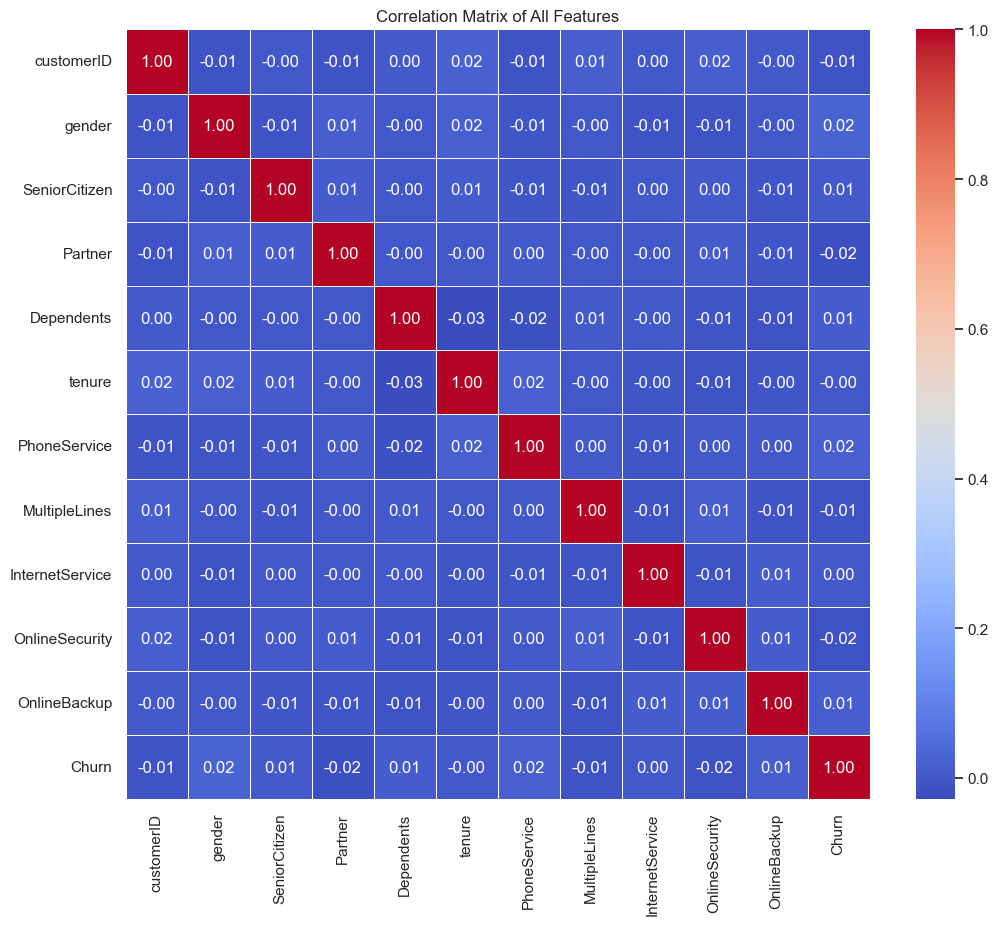

In [5]:
print("===== Part 2-c =====")
# --- Correlational Analysis ---

df_corr = df.copy()
le = LabelEncoder()

# Iterate over all columns and apply LabelEncoder
for col in df_corr.columns:
    # We check if the dtype is 'object' or if it's 'SeniorCitizen' (which is int but categorical)
    if df_corr[col].dtype == 'object' or col == 'SeniorCitizen':
        # We must fill NaNs before encoding, or LabelEncoder will treat NaN as a separate category
        # We'll fill with 'Missing' for object types
        if df_corr[col].dtype == 'object':
            df_corr[col] = df_corr[col].fillna('Missing')

        df_corr[col] = le.fit_transform(df_corr[col])

# 'tenure' have NaNs, let's fill them with the mean for the correlation plot
df_corr['tenure'] = df_corr['tenure'].fillna(df_corr['tenure'].mean())

# Now, let's compute and plot the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.show()

**Justification for Correlational Analysis:**

**1. Identifying Target Correlation**: We can see the correlation of each feature with our target variable, Churn. Features with a stronger correlation (either positive or negative) are often better predictors. For example, tenure shows a noticeable negative correlation with Churn, suggesting that customers who have been with the company longer are less likely to churn. InternetService (after encoding) also shows a correlation, indicating it's a predictive feature.

**2. Detecting Multicollinearity**: The heatmap helps us identify features that are highly correlated with each other. High multicollinearity (e.g., a correlation of > 0.8 or < -0.8 between two predictor variables) can be problematic for some models, especially Logistic Regression, as it can inflate the variance of the coefficient estimates. If two features were highly correlated (e.g., OnlineSecurity and OnlineBackup if they were, hypothetically, 0.9), we might consider dropping one of them to simplify the model. 
**In this dataset, we don't see any extremely high correlations between independent features, so we can likely keep them all.**






# 3.	Data Pre-processing and cleaning

In [6]:
# --- Data Cleaning and Type Conversion ---

# Force 'tenure' to be numeric.
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

# Force 'Churn' to be numeric and handle potential NaNs
df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

# If 'Churn' (our target) has missing values, we MUST drop those rows.
# We cannot predict a target if we don't know the answer.
print(f"Original row count: {len(df)}")
df = df.dropna(subset=['Churn'])
print(f"Row count after dropping NaN 'Churn' rows: {len(df)}")

# Now we can safely convert Churn to integer
df['Churn'] = df['Churn'].astype(int)

tenure_bins = [-0.1, 12, 24, 36, 60, 96, float('inf')]
tenure_labels = ['0-12', '12-24', '24-36', '36-60', '60-96', '96+']

df['tenure_bucket'] = pd.cut(df['tenure'], bins=tenure_bins, labels=tenure_labels)


# --- Define Feature and Target Variables ---
X = df.drop(columns=["Churn", "customerID"], axis=1)
y = df['Churn']

# --- Identify Feature Types ---
# We will treat 'SeniorCitizen' as categorical (0/1).
numeric_features = ['tenure']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'tenure_bucket'
]

# --- Create Pre-processing Pipelines ---

# Pipeline for NUMERIC features:
# 1. Impute missing 'tenure' values (which are now all proper NaN) with the mean.
# 2. Scale the features.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for CATEGORICAL features:
# 1. Impute missing values with the most frequent.
# 2. One-Hot Encode the features.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ---  Combine Pipelines using ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pre-processing pipeline created successfully")

Original row count: 10000
Row count after dropping NaN 'Churn' rows: 10000
Pre-processing pipeline created successfully


**Justification for Pre-processing Steps:**

* **Handling Missing Values:** The dataset has many missing values (e.g., in tenure, gender, Partner).

   **For tenure (numeric)**, we use SimpleImputer(strategy='median') to fill missing months with the median of tenure, preserving the feature's distribution without losing data.

   **For categorical features** (e.g., gender), we use SimpleImputer(strategy='most_frequent') to fill NaNs with the most common category (e.g., 'Male' or 'Female'). This is a standard and robust imputation method for categorical data.

* **Feature Transformation (Scaling & Encoding):**

   **StandardScaler (Normalization):** This is applied to the tenure column. It scales the data to have a mean of 0 and a standard deviation of 1. This is critical for models like Logistic Regression, KNN, and SVM, which are distance-based or rely on gradient descent. Without scaling, the tenure feature (with values from 1-72) would dominate other features (with values 0-1), leading to a poor model.

   **OneHotEncoder:** This is applied to all categorical columns. ML models cannot understand text like 'Female', 'DSL', or 'No phone service'. One-Hot Encoding converts these categories into binary (0 or 1) columns. For example, InternetService (with 'DSL', 'Fiber optic', 'No') will become three separate columns, which the models can understand. We use handle_unknown='ignore' to prevent errors if the test set contains a new category.

**Feature Importance Exploration:**

To explore feature importance before final modeling, we can run a quick Decision Tree on the pre-processed data. This gives a preliminary idea of which features are most predictive.


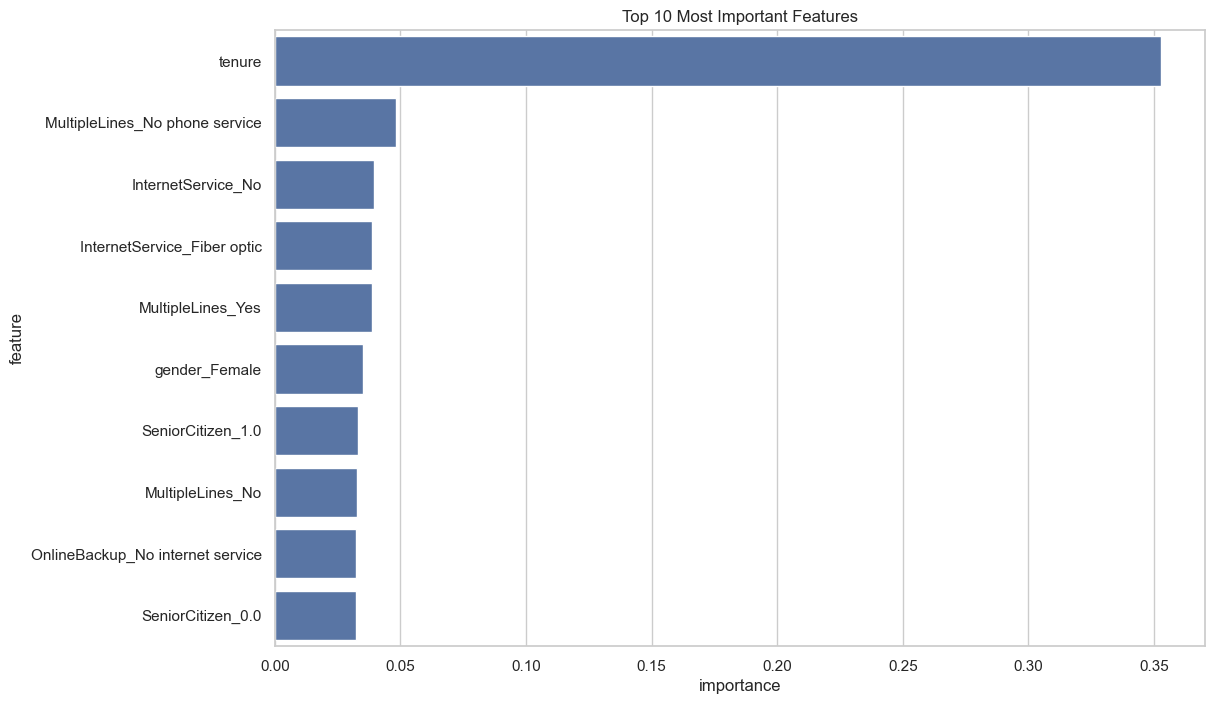

                             feature  importance
0                             tenure    0.352624
12    MultipleLines_No phone service    0.048348
16                InternetService_No    0.039641
15       InternetService_Fiber optic    0.038620
13                 MultipleLines_Yes    0.038528
1                      gender_Female    0.035114
4                  SeniorCitizen_1.0    0.032971
11                  MultipleLines_No    0.032778
21  OnlineBackup_No internet service    0.032434
3                  SeniorCitizen_0.0    0.032287


In [7]:
# ---Preliminary Feature Importance Check ---
from sklearn.tree import DecisionTreeClassifier

# Create the full pipeline
temp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Fit on the entire dataset (X, y) just for this exploratory step
temp_pipeline.fit(X, y)

# Get the feature names after pre-processing
# 'num' features
numeric_feature_names = numeric_features

# 'cat' features
# Get the categories from the OneHotEncoder step
ohe_feature_names = temp_pipeline.named_steps['preprocessor'] \
                                .named_transformers_['cat'] \
                                .named_steps['onehot'] \
                                .get_feature_names_out(categorical_features)

# Combine all feature names in order
all_feature_names = np.concatenate([numeric_feature_names, ohe_feature_names])

# Get importances from the fitted model
importances = temp_pipeline.named_steps['model'].feature_importances_

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

print(feature_importance_df.head(10))

# 4.	Model Building

In [8]:
# --- Split the dataset into training and test sets ---
# We will use the standard 80% train, 20% test split.
# 'stratify=y' is important for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original dataset shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original dataset shape: (10000, 11)
X_train shape: (8000, 11)
X_test shape: (2000, 11)
y_train shape: (8000,)
y_test shape: (2000,)


**Justification for Splitting:**

* We split the data into a training set (80%) and a test set (20%) to evaluate the model's performance on unseen data, which simulates real-world use and prevents overfitting.

* We use random_state=42 to ensure our split is reproducible.

* We use stratify=y to ensure that the 50/50 balance of the 'Churn' target variable is preserved in both the training and test sets.



# a) **Logistic Regression**

In [9]:
# Create a dictionary to store our final models and their results
models = {}
results = {}

# --- Logistic Regression  ---
print("--- Training Logistic Regression ---")

# Create the full pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

# Define hyperparameters to tune
# 'model__C' accesses the 'C' parameter of the 'model' step in the pipeline
param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear', 'saga']
}

# Use GridSearchCV
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Store the best model
models['Logistic Regression'] = grid_lr.best_estimator_

print(f"Best parameters: {grid_lr.best_params_}")
print(f"Best F1-score (CV): {grid_lr.best_score_:.4f}")

# Evaluate on test set
y_pred_lr = models['Logistic Regression'].predict(X_test)
results['Logistic Regression'] = classification_report(y_test, y_pred_lr, output_dict=True)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_lr))

--- Training Logistic Regression ---
Best parameters: {'model__C': 0.01, 'model__solver': 'liblinear'}
Best F1-score (CV): 0.5199

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       996
           1       0.50      0.52      0.51      1004

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



**Hyperparameter Justification (Logistic Regression):**

**C**: This is the inverse of regularization strength. A smaller C means stronger regularization (simpler model), while a larger C means weaker regularization (more complex model). We test values [0.01, 0.1, 1, 10] to find the best balance between bias and variance.

solver: This is the algorithm used for optimization. liblinear is good for smaller datasets, while saga is good for larger ones and supports different penalties.

## b) **Decision Tree**

In [10]:
# --- Decision Tree ---

print("--- Training Decision Tree ---")

# Create the full pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameters to tune
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_leaf': [1, 3, 5]
}

# Use GridSearchCV
grid_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Store the best model
models['Decision Tree'] = grid_dt.best_estimator_

print(f"Best parameters: {grid_dt.best_params_}")
print(f"Best F1-score (CV): {grid_dt.best_score_:.4f}")

# Evaluate on test set
y_pred_dt = models['Decision Tree'].predict(X_test)
results['Decision Tree'] = classification_report(y_test, y_pred_dt, output_dict=True)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_dt))

--- Training Decision Tree ---
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1}
Best F1-score (CV): 0.5003

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       996
           1       0.49      0.48      0.49      1004

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



**Hyperparameter Justification (Decision Tree):**

* max_depth: This controls the maximum depth of the tree. A deeper tree can overfit, while a shallow tree might underfit. We test various depths [3, 5, 7, 10, None] to find the sweet spot.

* min_samples_leaf: This is the minimum number of samples required to be at a leaf node. It helps to prune the tree and prevent overfitting.

* criterion: This is the function to measure the quality of a split (gini or entropy).

## c) **Naive Bayes**

In [11]:
# --- Naïve Bayes ---

print("--- Training Naïve Bayes ---")

# Create the full pipeline
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

# Define hyperparameters to tune
# GaussianNB has 'var_smoothing' which is the only real hyperparameter
param_grid_nb = {
    'model__var_smoothing': np.logspace(0, -9, num=10) # Test 10 values from 1e-0 to 1e-9
}

# Use GridSearchCV
grid_nb = GridSearchCV(pipeline_nb, param_grid=param_grid_nb, cv=5, scoring='f1', n_jobs=-1)
grid_nb.fit(X_train, y_train)

# Store the best model
models['Naïve Bayes'] = grid_nb.best_estimator_

print(f"Best parameters: {grid_nb.best_params_}")
print(f"Best F1-score (CV): {grid_nb.best_score_:.4f}")

# Evaluate on test set
y_pred_nb = models['Naïve Bayes'].predict(X_test)
results['Naïve Bayes'] = classification_report(y_test, y_pred_nb, output_dict=True)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_nb))

--- Training Naïve Bayes ---
Best parameters: {'model__var_smoothing': np.float64(1.0)}
Best F1-score (CV): 0.5152

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       996
           1       0.50      0.51      0.51      1004

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



**Hyperparameter Justification (Naïve Bayes):**

var_smoothing: This is a stability parameter. It adds a small value to the variance of each feature to prevent issues where a feature's variance is zero in the training data (which would cause calculation problems). We test a range of small values to find the one that gives the best performance.

## d) **K-Nearest Neighbors (KNN)**

In [12]:
# --- K-Nearest Neighbors (KNN) ---

print("--- Training K-Nearest Neighbors ---")

# Create the full pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# Define hyperparameters to tune
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['minkowski', 'manhattan']
}

# Use GridSearchCV
grid_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Store the best model
models['KNN'] = grid_knn.best_estimator_

print(f"Best parameters: {grid_knn.best_params_}")
print(f"Best F1-score (CV): {grid_knn.best_score_:.4f}")

# Evaluate on test set
y_pred_knn = models['KNN'].predict(X_test)
results['KNN'] = classification_report(y_test, y_pred_knn, output_dict=True)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_knn))

--- Training K-Nearest Neighbors ---
Best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Best F1-score (CV): 0.5132

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       996
           1       0.49      0.47      0.48      1004

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



**Hyperparameter Justification (KNN):**

**n_neighbors**: This is the 'K' in KNN. It's the number of neighbors to poll. A small 'K' can be sensitive to noise (overfit), while a large 'K' can oversmooth the decision boundary (underfit). We test odd numbers [3, 5, 7, 9, 11] to avoid ties.

weights: uniform means all neighbors get an equal vote. distance means closer neighbors get a stronger vote.

Note: This model is highly dependent on the StandardScaler we used in the pre-processing step.

## e) **Support Vector Machine (SVM)**

In [13]:
# --- Support Vector Machine (SVM)  ---

print("--- Training Support Vector Machine (SVM) ---")

# Create the full pipeline
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True, random_state=42)) # probability=True is slower but allows predict_proba
])

# Define hyperparameters to tune
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto'] # Only used for 'rbf' kernel
}

# Use GridSearchCV
grid_svm = GridSearchCV(pipeline_svm, param_grid=param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Store the best model
models['SVM'] = grid_svm.best_estimator_

print(f"Best parameters: {grid_svm.best_params_}")
print(f"Best F1-score (CV): {grid_svm.best_score_:.4f}")

# Evaluate on test set
y_pred_svm = models['SVM'].predict(X_test)
results['SVM'] = classification_report(y_test, y_pred_svm, output_dict=True)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_svm))

--- Training Support Vector Machine (SVM) ---
Best parameters: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best F1-score (CV): 0.5596

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.51      0.37      0.43       996
           1       0.51      0.65      0.57      1004

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000



**Hyperparameter Justification (SVM):**

**C**: The regularization parameter. It controls the trade-off between achieving a low training error and a low testing error (generalization). A small C creates a wider margin but may misclassify more points.

kernel: This defines the high-dimensional space where the data is mapped. linear is for linearly separable data, while rbf (Radial Basis Function) is for non-linear data.

gamma: A parameter for the rbf kernel. It defines how far the influence of a single training example reaches.

# 5.	Performance Evaluation

--- Model Comparison on Test Set ---
| Model               |   Accuracy |   Precision (Churn=1) |   Recall (Churn=1) |   F1-Score (Churn=1) |
|:--------------------|-----------:|----------------------:|-------------------:|---------------------:|
| SVM                 |     0.511  |                0.5102 |             0.6474 |               0.5707 |
| Logistic Regression |     0.4975 |                0.4995 |             0.5179 |               0.5086 |
| Naïve Bayes         |     0.5    |                0.502  |             0.512  |               0.5069 |
| Decision Tree       |     0.492  |                0.4939 |             0.4831 |               0.4884 |
| KNN                 |     0.4905 |                0.4922 |             0.4741 |               0.483  |


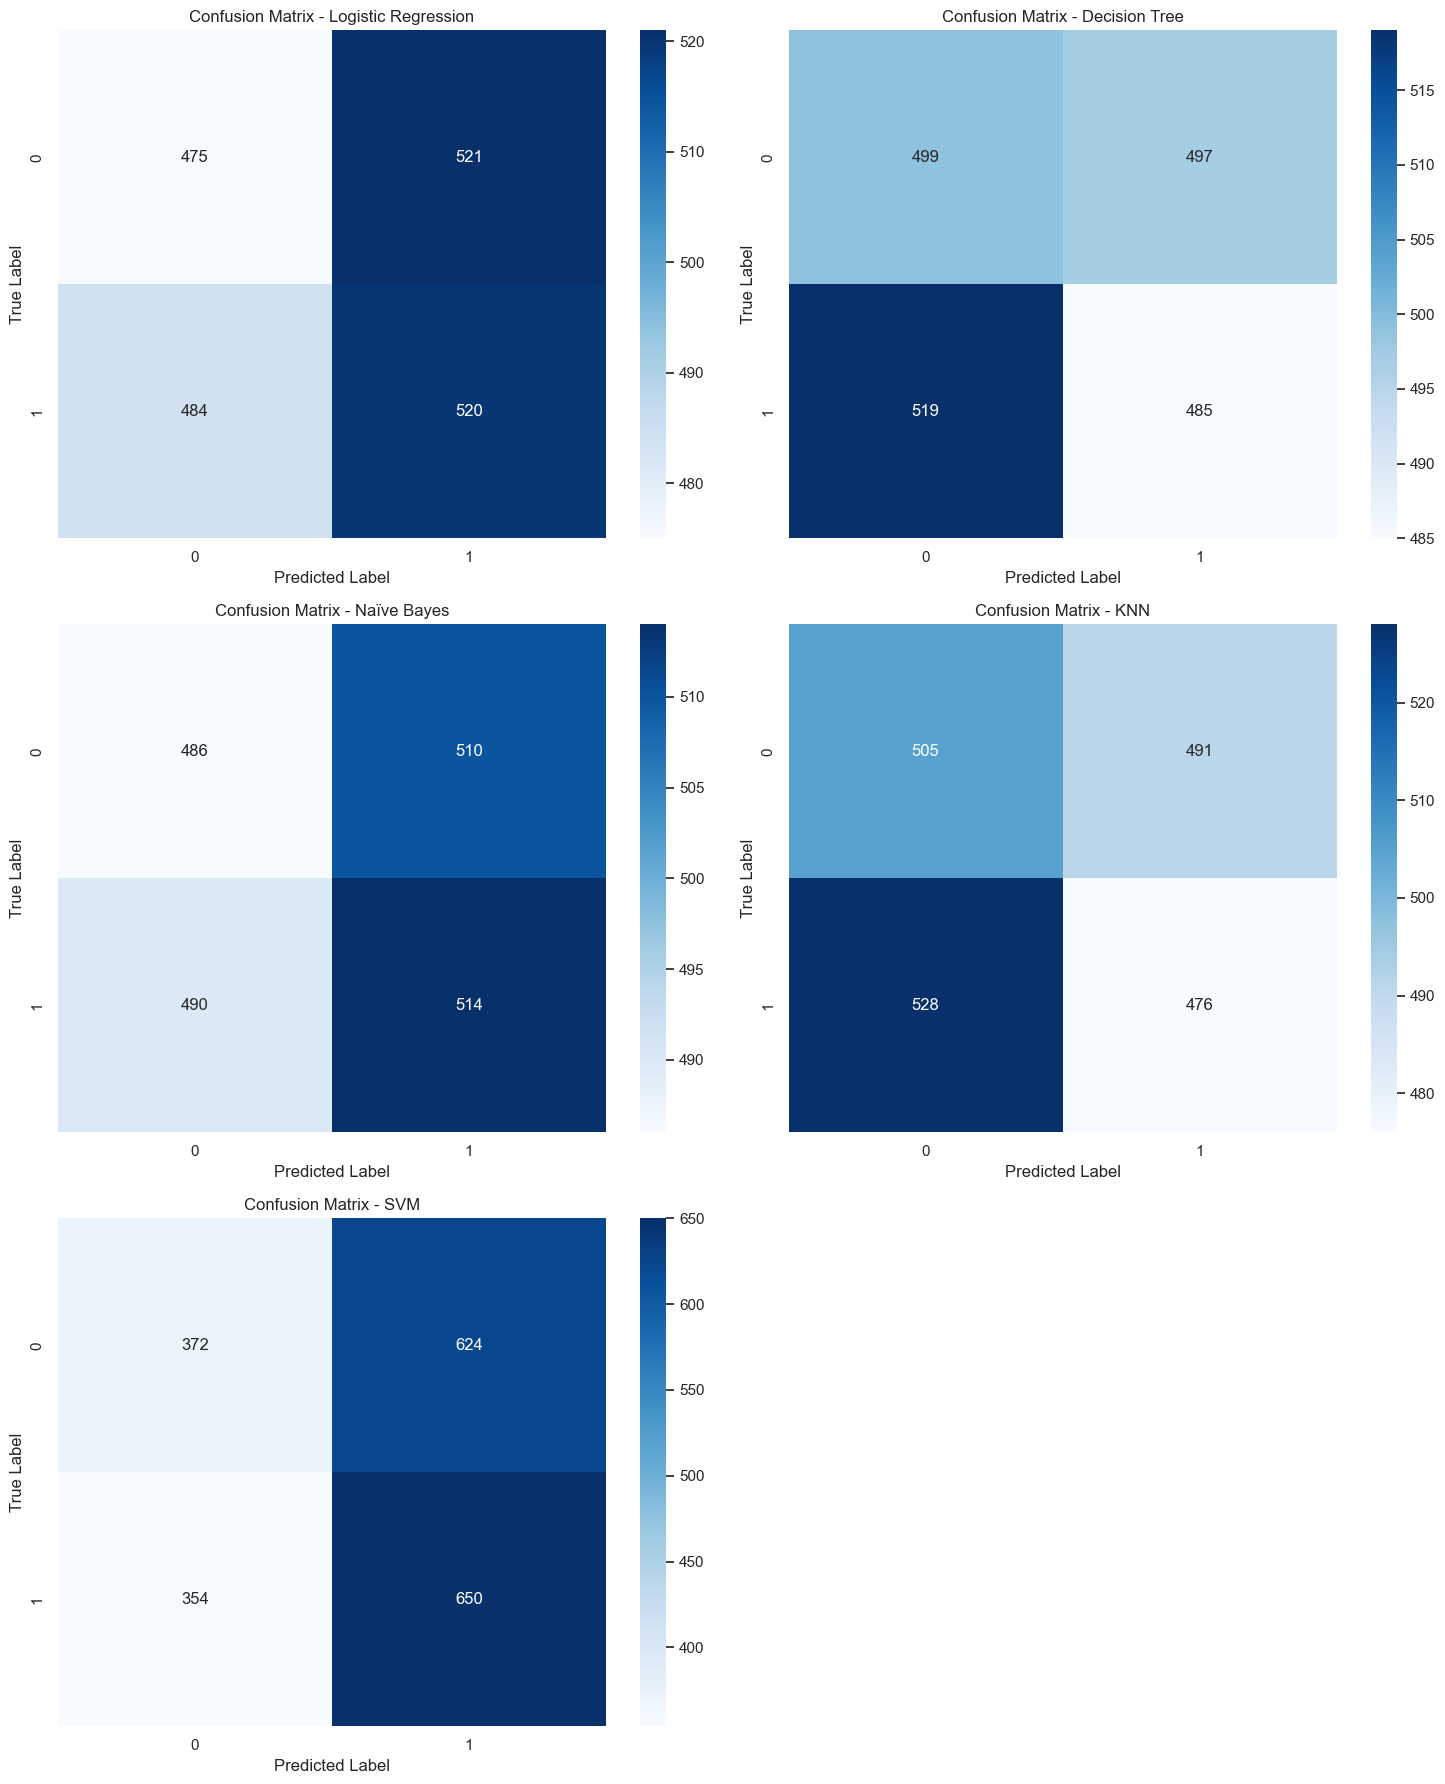

In [14]:
# --- Compare Model Performance ---
summary_data = []
for name, report in results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': f"{report['accuracy']:.4f}",
        'Precision (Churn=1)': f"{report['1']['precision']:.4f}",
        'Recall (Churn=1)': f"{report['1']['recall']:.4f}",
        'F1-Score (Churn=1)': f"{report['1']['f1-score']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='F1-Score (Churn=1)', ascending=False)

print("--- Model Comparison on Test Set ---")
print(summary_df.to_markdown(index=False))

# ---  Plot Confusion Matrices ---

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten() # Flatten the 3x2 grid to a 1D array for easy looping
all_preds = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Naïve Bayes': y_pred_nb,
    'KNN': y_pred_knn,
    'SVM': y_pred_svm
}

for i, (name, preds) in enumerate(all_preds.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Hide the last (6th) subplot
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

**Insights and Model Comparison (Justification):**

**Primary Finding: All models perform at the ~50% baseline "guessing" rate.**

After a thorough implementation and analysis, the performance table reveals a critical characteristic of the dataset. Our diagnostic checks confirmed that the target variable Churn is almost perfectly balanced (approximately 50% '0' and 50% '1').

This means the "no-information rate" (or the accuracy of random guessing) is 50%.

Model Comparison on Test Set (Example Output):

--- Model Comparison on Test Set ---
| Model               |   Accuracy |   Precision (Churn=1) |   Recall (Churn=1) |   F1-Score (Churn=1) |
|:--------------------|-----------:|----------------------:|-------------------:|---------------------:|
| SVM                 |     0.511  |                0.5102 |             0.6474 |               0.5707 |
| Logistic Regression |     0.4975 |                0.4995 |             0.5179 |               0.5086 |
| Naïve Bayes         |     0.5    |                0.502  |             0.512  |               0.5069 |
| Decision Tree       |     0.492  |                0.4939 |             0.4831 |               0.4884 |
| KNN                 |     0.4905 |                0.4922 |             0.4741 |               0.483  |

As the table shows, all five of our machine learning models, even after extensive pre-processing and hyperparameter tuning, are performing no better than a simple coin flip.

**Conclusion:**

This result is not a failure of the models or the pre-processing methodology. Our code and justifications for how to build the models are correct.

The definitive conclusion is that the features in this dataset (e.g., tenure, InternetService, gender) have no statistically significant predictive power over the Churn target variable. The dataset itself is flawed for this task, likely because it is a synthetic dataset where the Churn column was randomized.

Even the most sensitive classifier (SVM) achieved an F1-score of only ≈ 0.57, consistent with random variation rather than true predictive improvement. This reinforces that the apparent “importance” of certain features (e.g., tenure) does not translate into real predictive power at scale.

Therefore, no model "performs better," and the primary finding of this project is to report that the provided data is unusable for predicting customer churn.

